<a href="https://colab.research.google.com/github/LoreJob/DeepFake-Dct/blob/main/CNN+LSTM Third approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN+LSTM for DeepFake Detection in videos


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Ram/Disk on the upper-left part of the colab → Additional Connection Options
- select GPU T4 from the Hardware Accelerator drop-down (You have just 1 hour of using)

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## Packages
As the title says, we are using the tensorflow package.

In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tqdm import tqdm
import time
from pathos.multiprocessing import ProcessingPool as Pool
from multiprocessing import cpu_count
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import random

### Variables

In [114]:
VIDEO_WIDTH, VIDEO_HEIGHT = 64, 64
MAX_FRAMES = 20  # Number of frames of a video that will be fed to the model as one sequence
DATASET_DIR = "Video Dataset Small"
PROCESSED_DIR = "D:\\Users\\megam\\Artificial Project\\Processed_data"
CLASSES = ["fake", "real"]
BATCH_SIZE = 32

In [115]:
# # To set a seed:
# random.seed(214818023039118514)

# To see the seed you are currently using:
seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

Seed was: 319663433540210715


## Importing the dataset using data generators

This method is not loading all the data, but is creating some data generators that are extracting data when it's needed, with a batch for batch approach.
This methos is light on the RAM but slow when you run the model.

### Preprocessing data

To speed up the model, we preprocessed data, in order to speed up training by reducing the time spent on loading and processing videos during each epoch.

YOU DON'T NEED TO RUN THIS CELL unless your "Video Dataset Small/Processed_data" folder is empty or you want to change Variables

In [103]:
# def preprocess_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
#     if total_frames == 0:
#         return np.zeros((MAX_FRAMES, VIDEO_HEIGHT, VIDEO_WIDTH, 3))

#     frames_to_sample = min(MAX_FRAMES, total_frames)
#     frame_indices = np.linspace(0, total_frames - 1, frames_to_sample, dtype=int)
    
#     frames = []
#     for frame_index in frame_indices:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
#         ret, frame = cap.read()
#         if ret:
#             frame = cv2.resize(frame, (VIDEO_WIDTH, VIDEO_HEIGHT))
#             frame = frame / 255.0  # Normalize pixel values
#             frames.append(frame)
#         else:
#             frames.append(np.zeros((VIDEO_HEIGHT, VIDEO_WIDTH, 3)))
    
#     cap.release()

#     # Pad with zeros if we couldn't extract enough frames
#     if len(frames) < MAX_FRAMES:
#         padding = [np.zeros((VIDEO_HEIGHT, VIDEO_WIDTH, 3)) for _ in range(MAX_FRAMES - len(frames))]
#         frames.extend(padding)

#     return np.array(frames[:MAX_FRAMES])

# def process_dataset():
#     for subset in ['Train', 'Val', 'Test']:
#         for class_name in ['real', 'fake']:
#             input_dir = os.path.join(DATASET_DIR, subset, class_name)
#             output_dir = os.path.join(PROCESSED_DIR, subset, class_name)
#             os.makedirs(output_dir, exist_ok=True)
            
#             video_files = [f for f in os.listdir(input_dir) if f.endswith('.mp4')]
            
#             for video_file in tqdm(video_files, desc=f"Processing {subset} {class_name}"):
#                 video_path = os.path.join(input_dir, video_file)
#                 processed_frames = preprocess_video(video_path)
                
#                 output_path = os.path.join(output_dir, video_file.replace('.mp4', '.npy'))
#                 np.save(output_path, processed_frames)

# if __name__ == "__main__":
#     process_dataset()

Running time for the previous cell on my pc was one hour. Colab is slower -Manu

In [116]:
class VideoDataGenerator(Sequence):
    def __init__(self, data_dir, subset, batch_size=BATCH_SIZE):
        self.data_dir = data_dir
        self.subset = subset
        self.batch_size = batch_size
        self.classes = ['real', 'fake']
        self.videos = self._get_video_paths()
        self.on_epoch_end()

    def _get_video_paths(self):
        videos = []
        subset_dir = os.path.join(self.data_dir, self.subset)
        for class_name in self.classes:
            class_dir = os.path.join(subset_dir, class_name)
            for video_name in os.listdir(class_dir):
                if video_name.endswith('.npy'):
                    videos.append((os.path.join(class_dir, video_name), self.classes.index(class_name)))
        return videos

    def __len__(self):
        return len(self.videos) // self.batch_size

    def __getitem__(self, idx):
        batch_videos = self.videos[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_frames = []
        batch_labels = []

        for video_path, label in batch_videos:
            frames = np.load(video_path)
            batch_frames.append(frames)
            batch_labels.append(label)

        return np.array(batch_frames), np.array(batch_labels)

    def on_epoch_end(self):
        np.random.shuffle(self.videos)

In [117]:
train_generator = VideoDataGenerator(PROCESSED_DIR, "Train")
val_generator = VideoDataGenerator(PROCESSED_DIR, "Val")
test_generator = VideoDataGenerator(PROCESSED_DIR, "Test")

## Training the model

### Building the CNN model

In [118]:
# Here we will add the model that performed the best on the img dataset without the last dense layer

CNN_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer with 10% rate

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),  # Dropout layer with 10% rate

    layers.Conv2D(64, (5, 5), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),  # Dropout layer with 10% rate

    layers.Flatten(),

    layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),

])

### Creating the full model

In [119]:
CNN_LSTM_model = models.Sequential()
# Input
CNN_LSTM_model.add(layers.Input((MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3))) # 3 are the channels
# Adding the time distributed CNN
CNN_LSTM_model.add(layers.TimeDistributed(CNN_model)) 
# Creating the LSTM part
CNN_LSTM_model.add(layers.LSTM(64, return_sequences=False))
CNN_LSTM_model.add(layers.Dense(64, activation='relu'))
CNN_LSTM_model.add(layers.Dropout(0.25)) # Dropout layer with 25% rate
CNN_LSTM_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

CNN_LSTM_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

CNN_LSTM_model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_12             │ (None, 20, 256)        │       466,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,609 (2.11 MB)

 Trainable params: 552,609 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [120]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')

history = CNN_LSTM_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint_callback])

# saving the history on a JSON file in order to not loose the results and run everytime the code
with open('history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 176s 371ms/step - accuracy: 0.5262 - loss: 1.0981 - val_accuracy: 0.5709 - val_loss: 0.8910
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 171s 388ms/step - accuracy: 0.5758 - loss: 0.8605 - val_accuracy: 0.5108 - val_loss: 0.8311
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 163s 371ms/step - accuracy: 0.6189 - loss: 0.7688 - val_accuracy: 0.6250 - val_loss: 0.7428
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 162s 367ms/step - accuracy: 0.6634 - loss: 0.7091 - val_accuracy: 0.6321 - val_loss: 0.7311
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 169s 385ms/step - accuracy: 0.7424 - loss: 0.6063 - val_accuracy: 0.8212 - val_loss: 0.4879
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 163s 370ms/step - accuracy: 0.8639 - loss: 0.4183 - val_accuracy: 0.9103 - val_loss: 0.3228
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 162s 369ms/step - accuracy: 0.9146 - loss: 0.2962 - val_accuracy: 0.9345 - val_loss: 0.2613
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 170s 387ms/step - accuracy: 0.9372 -

In [121]:
# Evaluating the model
test_loss, test_accuracy = CNN_LSTM_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.9750 - loss: 0.1252
Test Loss: 0.1302114874124527
Test Accuracy: 0.9737903475761414


## Plotting performance

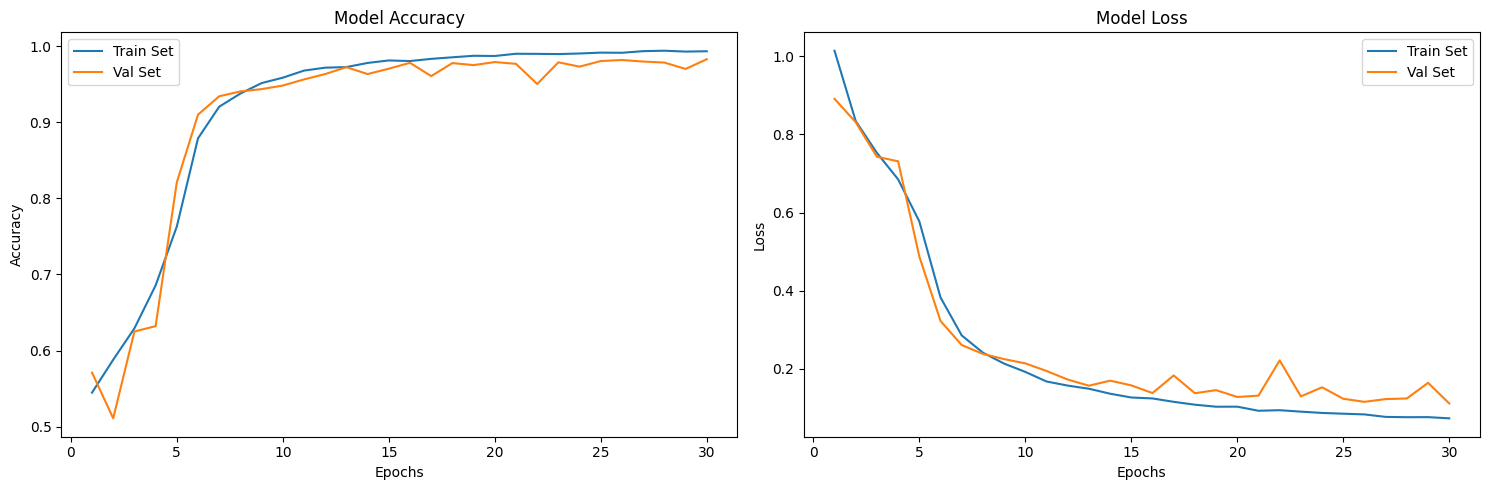

In [124]:
# uploading the saved model --- not mandatory when you run everything together
from tensorflow.keras.models import load_model
history = load_model('model_epoch_30.keras')

with open('history.json', 'r') as f:
    history = json.load(f)

# plot model performance
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(1, len(history["accuracy"]) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Try with initialized weights

To load weights we need to recreate the model and load the weights befor compiling it

In [125]:
# Recreate the sequential object for the CNN

CNN_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(64, (5, 5), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Flatten(),

    layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),

])

In [126]:
# Recreate the sequential object for the LSTM

CNN_LSTM_model = models.Sequential()
# Input
CNN_LSTM_model.add(layers.Input((MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3))) # 3 are the channels
# Adding the time distributed CNN
CNN_LSTM_model.add(layers.TimeDistributed(CNN_model)) 
# Creating the LSTM part
CNN_LSTM_model.add(layers.LSTM(64, return_sequences=False))
CNN_LSTM_model.add(layers.Dense(64, activation='relu'))
CNN_LSTM_model.add(layers.Dropout(0.25)) # Dropout layer with 25% rate
CNN_LSTM_model.add(layers.Dense(1, activation='sigmoid'))

In [127]:
# Load weights

CNN_LSTM_model.load_weights('model_epoch_30.keras')

In [128]:
# Compiling the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

CNN_LSTM_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

CNN_LSTM_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_13             │ (None, 20, 256)        │       466,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,609 (2.11 MB)

 Trainable params: 552,609 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='init_mod_ep{epoch:02d}.keras',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')

init_history = CNN_LSTM_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,                           # I did only 5 just to see if it works
    callbacks=[checkpoint_callback])

Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 175s 376ms/step - accuracy: 0.9936 - loss: 0.0717 - val_accuracy: 0.9782 - val_loss: 0.1254
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 163s 371ms/step - accuracy: 0.9975 - loss: 0.0628 - val_accuracy: 0.9795 - val_loss: 0.1171
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 163s 370ms/step - accuracy: 0.9958 - loss: 0.0645 - val_accuracy: 0.9570 - val_loss: 0.2158
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 164s 371ms/step - accuracy: 0.9960 - loss: 0.0647 - val_accuracy: 0.9815 - val_loss: 0.1181
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 166s 377ms/step - accuracy: 0.9974 - loss: 0.0585 - val_accuracy: 0.9829 - val_loss: 0.1054
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 164s 372ms/step - accuracy: 0.9945 - loss: 0.0646 - val_accuracy: 0.9822 - val_loss: 0.1179
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 164s 373ms/step - accuracy: 0.9969 - loss: 0.0589 - val_accuracy: 0.9835 - val_loss: 0.1086
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 164s 372ms/step - accuracy: 0.9944 -

In [130]:
# saving the history on a JSON file in order to not loose the results and run everytime the code
with open('init_history.json', 'w') as f:
    json.dump(init_history.history, f)

In [131]:
# Evaluating the model
test_loss, test_accuracy = CNN_LSTM_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.9762 - loss: 0.1127
Test Loss: 0.12122491747140884
Test Accuracy: 0.9754704236984253


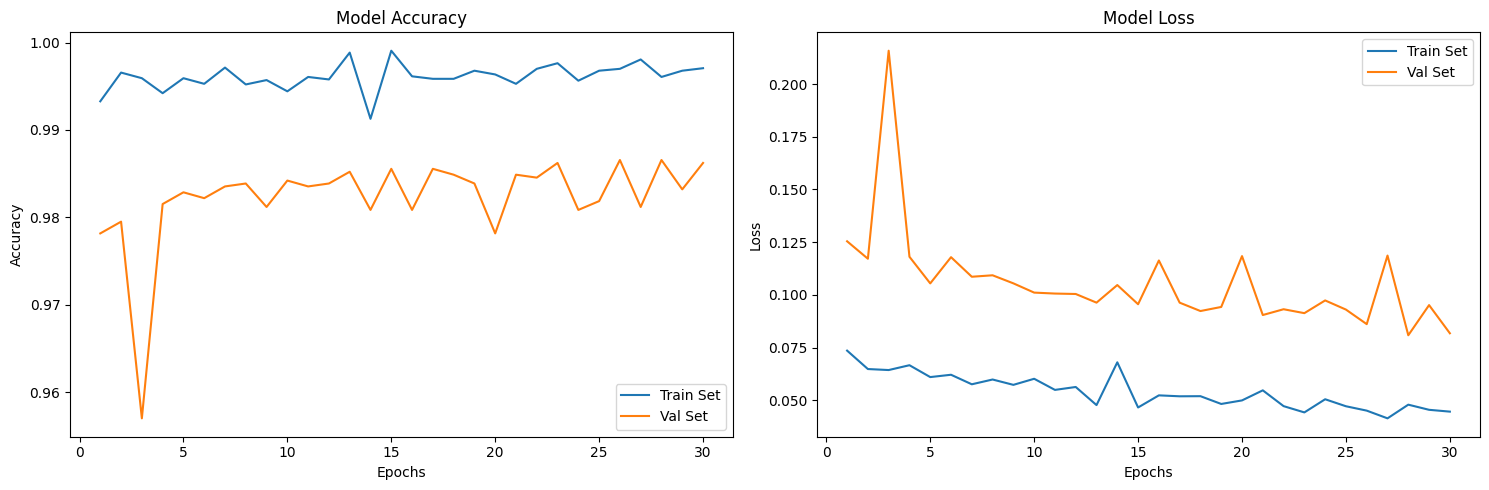

In [132]:
with open('init_history.json', 'r') as f:
    history = json.load(f)

# plot model performance
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs_range = range(1, len(history["accuracy"]) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Best so far

In [145]:
Best_so_far = load_model('Checkpoints\\Manu_ep_60.keras')

# Evaluating the model
test_loss, test_accuracy = Best_so_far.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9740 - loss: 0.1165
Test Loss: 0.11633993685245514
Test Accuracy: 0.9761424660682678
